--- 1. Configuración de Conexión y Carga de Datos ---
✅ Datos cargados exitosamente de la base de datos local 'Tipvos'.

Primeras 5 filas de df_ventas:
   id invoice      fecha  customer_id stockcode  cantidad  precio_unitario
0   1  489434 2009-12-01        13085     85048        12             6.95
1   2  489434 2009-12-01        13085    79323P        12             6.75
2   3  489434 2009-12-01        13085    79323W        12             6.75
3   4  489434 2009-12-01        13085     22041        48             2.10
4   5  489434 2009-12-01        13085     21232        24             1.25

--- 3. Preparación de Datos para Series de Tiempo (Agregación Mensual) ---

Primeras 10 filas de ventas mensuales por producto:
  stockcode    año_mes  cantidad_vendida_mes  monto_vendido_mes  \
0     10002 2009-12-01                   213             181.05   
1     10002 2010-01-01                   289             245.65   
2     10002 2010-02-01                   255             216.75   
3

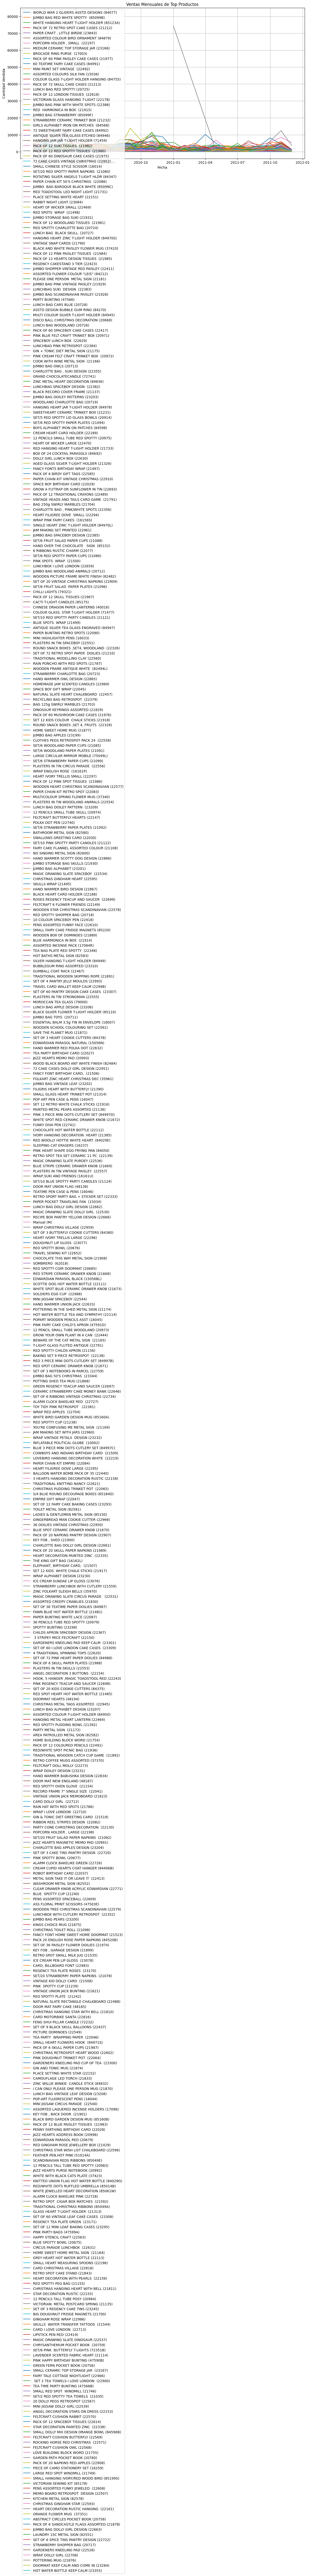


--- 4. Modelado de Series de Tiempo (ARIMA para cada Producto) ---
Se entrenará el modelo hasta: 2011-12 y se predecirá para: 2012-01

Modelando para producto: 84077
Mejor modelo ARIMA para WORLD WAR 2 GLIDERS ASSTD DESIGNS: ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-17.52

Modelando para producto: 85099B
Mejor modelo ARIMA para JUMBO BAG RED WHITE SPOTTY : ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-18.82

Modelando para producto: 85123A
Mejor modelo ARIMA para WHITE HANGING HEART T-LIGHT HOLDER: ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-0.55

Modelando para producto: 21212
Mejor modelo ARIMA para PACK OF 72 RETRO SPOT CAKE CASES: ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-3.77

Modelando para producto: 23843
Mejor modelo ARIMA para PAPER CRAFT , LITTLE BIRDIE: ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2.00

Modelando para producto: 84879
Mejor modelo ARIMA para ASSORTED COLOUR BIRD ORNAMENT: ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-18.96

Modelando para producto: 22197
Mejor modelo ARIMA para POPCORN HOLDER , 

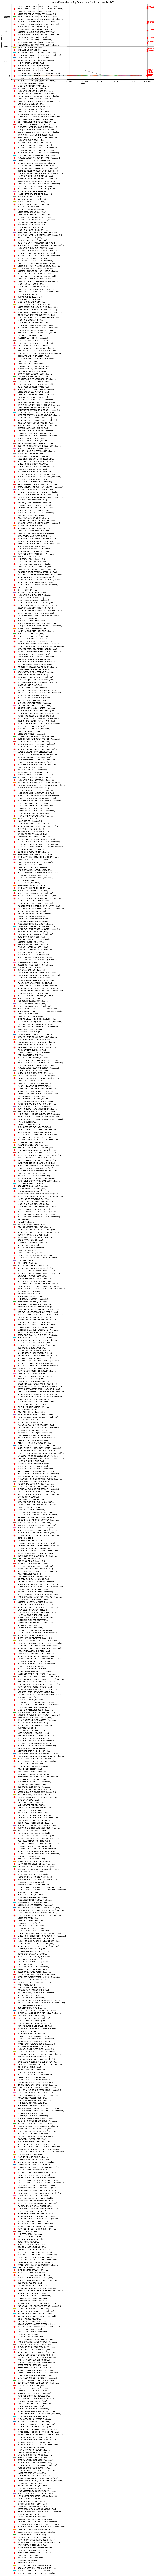

In [4]:
# --- 0. Configuración Inicial en Google Colab ---
# Instalar librerías (ejecutar solo si no están instaladas)
# !pip install sqlalchemy psycopg2-binary pandas scikit-learn matplotlib seaborn xgboost statsmodels pmdarima

# Importar librerías necesarias
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
# Librerías para series de tiempo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore") # Para ignorar warnings de statsmodels

# --- 1. Configuración de Conexión a la Base de Datos PostgreSQL Local ---
print("--- 1. Configuración de Conexión y Carga de Datos ---")

# Detalles de conexión a tu base de datos PostgreSQL local
db_user = 'postgres'
db_password = 'postgres'
db_host = 'localhost'
db_port = '5433'
db_name = 'Tipvos' # Nombre de la base de datos

# Construir la cadena de conexión
engine_string = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(engine_string)

# --- 2. Conexión a la Base de Datos y Carga de Datos ---
try:
    df_ventas = pd.read_sql("SELECT * FROM fact_ventas", engine)
    df_productos = pd.read_sql("SELECT * FROM dim_producto", engine)
    print(f"✅ Datos cargados exitosamente de la base de datos local '{db_name}'.")
except Exception as e:
    print(f"❌ Error al cargar datos: {e}")
    print("Asegúrate de que la base de datos PostgreSQL local esté accesible y las tablas existan.")
    raise # Relanza la excepción para detener la ejecución si falla la carga

# Convertir 'fecha' a tipo datetime
df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'])

print("\nPrimeras 5 filas de df_ventas:")
print(df_ventas.head())

# --- 3. Preparación de Datos para Series de Tiempo (Agregación Mensual) ---
print("\n--- 3. Preparación de Datos para Series de Tiempo (Agregación Mensual) ---")
# Calcular el monto total de venta por transacción
df_ventas['monto_venta'] = df_ventas['cantidad'] * df_ventas['precio_unitario']

# Asegurarse de que no haya cantidades negativas o precios unitarios <= 0 que puedan distorsionar
df_ventas = df_ventas[(df_ventas['cantidad'] > 0) & (df_ventas['precio_unitario'] > 0)]

# Crear una columna de mes/año para agrupar
df_ventas['año_mes'] = df_ventas['fecha'].dt.to_period('M')

# Agregamos la cantidad total vendida y el monto total de venta por producto y por mes
df_ventas_mensuales_producto = df_ventas.groupby(['stockcode', 'año_mes']).agg(
    cantidad_vendida_mes=('cantidad', 'sum'),
    monto_vendido_mes=('monto_venta', 'sum'),
    num_transacciones_mes=('id', 'count')
).reset_index()

# Unir con la descripción del producto
df_ventas_mensuales_producto = df_ventas_mensuales_producto.merge(
    df_productos[['stockcode', 'descripcion']], on='stockcode', how='left'
)

# Convertir 'año_mes' a datetime para facilitar el manejo de series de tiempo
df_ventas_mensuales_producto['año_mes'] = df_ventas_mensuales_producto['año_mes'].dt.to_timestamp()

print("\nPrimeras 10 filas de ventas mensuales por producto:")
print(df_ventas_mensuales_producto.head(10))
print(f"\nNúmero total de entradas de ventas mensuales por producto: {df_ventas_mensuales_producto.shape[0]}")

# Identificar los N productos más vendidos para modelar (para no modelar miles de series)
top_products = df_ventas_mensuales_producto.groupby('stockcode')['cantidad_vendida_mes'].sum().nlargest(500).index.tolist()
print(f"\nTop 5 productos más vendidos seleccionados para modelado: {top_products}")

# Filtrar el DataFrame para solo estos productos
df_top_products = df_ventas_mensuales_producto[df_ventas_mensuales_producto['stockcode'].isin(top_products)].copy()

# Opcional: Visualizar las series de tiempo para estos productos
plt.figure(figsize=(15, 8))
for product_code in top_products:
    product_data = df_top_products[df_top_products['stockcode'] == product_code].set_index('año_mes').sort_index()
    product_description = df_productos[df_productos['stockcode'] == product_code]['descripcion'].iloc[0]
    plt.plot(product_data.index, product_data['cantidad_vendida_mes'], label=f'{product_description} ({product_code})')
plt.title('Ventas Mensuales de Top Productos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.legend()
plt.grid(True)
plt.show()

# --- 4. Modelado de Series de Tiempo (ARIMA para cada Producto) ---
print("\n--- 4. Modelado de Series de Tiempo (ARIMA para cada Producto) ---")

# Vamos a predecir el próximo mes. Primero, definimos el período de entrenamiento y prueba.
last_month_data = df_top_products['año_mes'].max()
mes_a_predecir = last_month_data + pd.DateOffset(months=1)
print(f"Se entrenará el modelo hasta: {last_month_data.strftime('%Y-%m')} y se predecirá para: {mes_a_predecir.strftime('%Y-%m')}")

predicciones_futuras = {}

for product_code in top_products:
    print(f"\nModelando para producto: {product_code}")
    product_data_series = df_top_products[df_top_products['stockcode'] == product_code].set_index('año_mes').sort_index()
    product_description = df_productos[df_productos['stockcode'] == product_code]['descripcion'].iloc[0]

    # Asegurarse de que la serie de tiempo sea completa (rellenar meses faltantes con 0 si es necesario)
    idx = pd.date_range(start=product_data_series.index.min(), end=product_data_series.index.max(), freq='MS')
    product_data_series = product_data_series.reindex(idx, fill_value=0) # Rellenar con 0 si no hubo ventas

    # Usamos la cantidad vendida como la serie principal
    ts = product_data_series['cantidad_vendida_mes']

    # Aplicar transformación logarítmica a la serie de tiempo para el modelado
    ts_log = np.log1p(ts)

    # --- Búsqueda de los mejores parámetros ARIMA (p, d, q) ---
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    search_combinations = itertools.product(pdq, seasonal_pdq)
    tested_combinations = 0
    max_combinations_to_test = 200

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            if tested_combinations >= max_combinations_to_test:
                break
            try:
                # Usar ts_log para el entrenamiento
                model = ARIMA(ts_log, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = param
                    best_seasonal_order = param_seasonal
                    best_model = results
            except Exception as e:
                # print(f'Error con ARIMA{param}x{param_seasonal}12 para {product_code}: {e}') # Descomentar para debug
                continue
            tested_combinations += 1
        if tested_combinations >= max_combinations_to_test:
            break

    predicted_value = 0 # Valor por defecto si no se puede modelar o predecir

    if best_model:
        print(f"Mejor modelo ARIMA para {product_description}: ARIMA{best_order}x{best_seasonal_order}12 - AIC:{best_aic:.2f}")
        try:
            # Realizar la predicción para el siguiente mes usando la serie log-transformada
            forecast = best_model.predict(start=len(ts_log), end=len(ts_log), dynamic=False)
            predicted_value_log = forecast.iloc[0]

            # Deshacer la transformación logarítmica
            predicted_value = np.expm1(predicted_value_log)

            # --- MANEJO DE VALORES EXTREMOS ---
            # Asegurarse de que la predicción no sea negativa
            if predicted_value < 0:
                predicted_value = 0
            # Asegurarse de que la predicción no sea infinita o un número irrealmente grande
            if not np.isfinite(predicted_value) or predicted_value > 1e6: # Limite superior de 1 millón de unidades
                predicted_value = ts.mean() # Si es demasiado grande, usa la media histórica
                if predicted_value == 0: # Si la media también es 0 (ej. producto sin ventas)
                    predicted_value = 1 # O un valor mínimo sensato

            predicted_value = round(predicted_value) # Redondear a entero para cantidades

        except Exception as e:
            print(f"Error al predecir para {product_description}: {e}")
            predicted_value = ts.mean() # Recurrir a la media si hay un error en la predicción
            if predicted_value == 0:
                predicted_value = 1
            predicted_value = round(predicted_value)

    else:
        print(f"No se pudo encontrar un modelo ARIMA válido para {product_description}. Prediciendo con la media.")
        predicted_value = ts.mean() # Si no hay modelo, usa la media histórica
        if predicted_value == 0:
            predicted_value = 1
        predicted_value = round(predicted_value)


    # Almacenar modelo entrenado también (si existe)
    modelo_arima = best_model if best_model else None

    predicciones_futuras[product_code] = {
        'descripcion': product_description,
        'mes_prediccion': mes_a_predecir.strftime('%Y-%m'),
        'cantidad_predicha': predicted_value,
        'modelo_entrenado': modelo_arima
    }


# Convertir las predicciones a un DataFrame
df_predicciones_mensuales = pd.DataFrame.from_dict(predicciones_futuras, orient='index')
df_predicciones_mensuales.reset_index(inplace=True)
df_predicciones_mensuales.rename(columns={'index': 'stockcode'}, inplace=True)

print("\n--- Predicciones de Cantidad de Venta para el Próximo Mes ---")
print(df_predicciones_mensuales.sort_values(by='cantidad_predicha', ascending=False))

# Opcional: Visualizar la predicción junto con la serie histórica
plt.figure(figsize=(15, 8))
for product_code in top_products:
    product_data = df_top_products[df_top_products['stockcode'] == product_code].set_index('año_mes').sort_index()
    product_description = df_productos[df_productos['stockcode'] == product_code]['descripcion'].iloc[0]
    plt.plot(product_data.index, product_data['cantidad_vendida_mes'], label=f'{product_description} (Real)')

    # Añadir el punto de predicción
    if product_code in predicciones_futuras:
        predicted_month_dt = pd.to_datetime(predicciones_futuras[product_code]['mes_prediccion'])
        predicted_qty = predicciones_futuras[product_code]['cantidad_predicha']
        # Asegurarse de que predicted_qty sea un número finito antes de intentar convertirlo a int
        if np.isfinite(predicted_qty):
            plt.scatter(predicted_month_dt, predicted_qty, color='red', s=100, zorder=5, label=f'{product_description} (Predicción)')
            plt.text(predicted_month_dt, predicted_qty, f' {int(predicted_qty)}', ha='left', va='bottom', fontsize=9, color='red')
        else:
            print(f"Advertencia: Predicción no finita para {product_description}. No se añadió texto al gráfico.")


plt.title(f'Ventas Mensuales de Top Productos y Predicción para {mes_a_predecir.strftime("%Y-%m")}')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
import os
import joblib

# Guardar modelos entrenados
for product_code, datos in predicciones_futuras.items():
    modelo = datos.get('modelo_entrenado')
    if modelo:
        ruta_modelo = f'../models/arima_model_{product_code}.pkl'
        joblib.dump(modelo, ruta_modelo)
        print(f"✅ Modelo de {product_code} guardado en: {ruta_modelo}")


✅ Modelo de 84077 guardado en: ../models/arima_model_84077.pkl
✅ Modelo de 85099B guardado en: ../models/arima_model_85099B.pkl
✅ Modelo de 85123A guardado en: ../models/arima_model_85123A.pkl
✅ Modelo de 21212 guardado en: ../models/arima_model_21212.pkl
✅ Modelo de 23843 guardado en: ../models/arima_model_23843.pkl
✅ Modelo de 84879 guardado en: ../models/arima_model_84879.pkl
✅ Modelo de 22197 guardado en: ../models/arima_model_22197.pkl
✅ Modelo de 23166 guardado en: ../models/arima_model_23166.pkl
✅ Modelo de 17003 guardado en: ../models/arima_model_17003.pkl
✅ Modelo de 21977 guardado en: ../models/arima_model_21977.pkl
✅ Modelo de 84991 guardado en: ../models/arima_model_84991.pkl
✅ Modelo de 22492 guardado en: ../models/arima_model_22492.pkl
✅ Modelo de 15036 guardado en: ../models/arima_model_15036.pkl
✅ Modelo de 84755 guardado en: ../models/arima_model_84755.pkl
✅ Modelo de 21213 guardado en: ../models/arima_model_21213.pkl
✅ Modelo de 20725 guardado en: ../models/arima_mode